# **Fashion Foresight**

>## **Introduction**
For many individuals, selecting an outfit can consume a considerable amount of time. Fashion Foresight aims to assist users in comprehending their clothing collection to determine the categorization of their apparel. Numerous college students find it challenging to recognize their fashion style due to the ever-changing nature of the industry. This predicament often leads to succumbing to the temptation of fast fashion, which not only wastes money and time but also has a detrimental impact on the environment. Despite 62% of post-secondary students belonging to the Gen Z demographic considering sustainability while purchasing fashion items, this trend persists (Petro, 2020). The tool helps students to identify the fashion category that their wardrobe items fit into, simplifying the task of developing a fashion sense and introducing them to new styles. By comprehending their current fashion library, they can make well-informed buying decisions, minimize their contribution to fast fashion, and reduce the need for frequent wardrobe upgrades. To utilize Fashion Foresight, a user only needs to capture an image of their clothing item, and the tool's computer vision model will produce a style label that best matches the clothing piece. This method enables users to rapidly create an outfit that aligns with their desired appearance.






>## **Data Description**
The dataset used to train our model was called Fashion Product Images and sourced from Kaggle. This dataset consists of two CSVs, images.csv and styles.csv. Images.csv contains 2 columns, the first being filename and the other being a link to an image of clothing. Styles.csv contains 10 columns where the first is a unique id that corresponds to the matching filename column in images.csv, and the rest are features used to describe the article of clothing like gender, article type, usage, and so on. After merging the two CSVs, the resulting consolidated dataset was used for exploratory data analysis. Based on this analysis, the dataset was split randomly into training, validation, and test sets in a 70:15:15 ratio. The training set was used to train the machine learning model, the validation set was used to fine-tune its hyperparameters, and the test set was used to evaluate the final performance of the model on new, unseen data. This process ensured that the model was able to generalize well and perform accurately on real-world data. Link to the dataset can be found [here](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset).

>## **Data Cleaning, Data Transformation, Feature Engineering**
The original dataset presented several challenges when used initially for training. One significant issue was the imbalanced distribution of style classes, with more than 70% of the dataset consisting of casual styles.
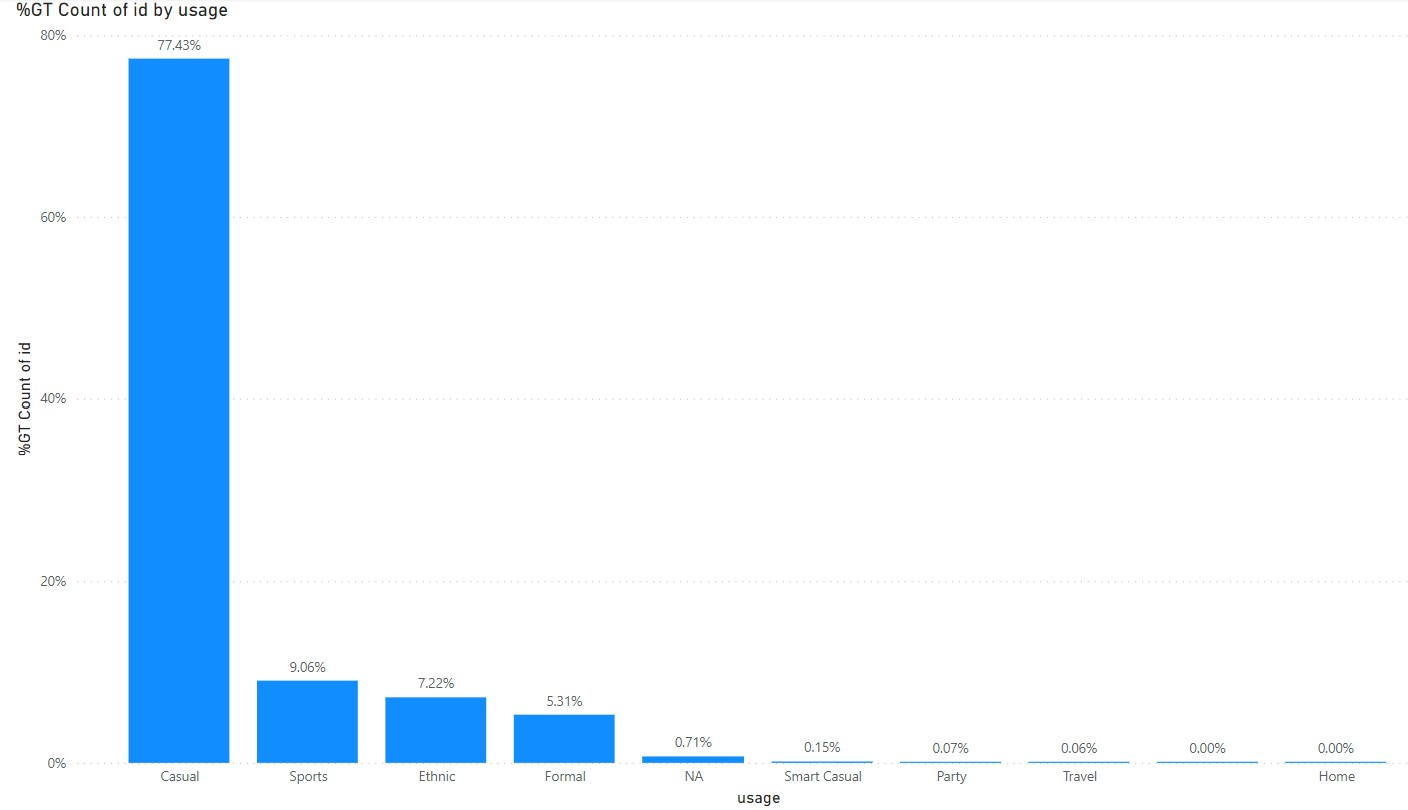\
Moreover, from the above visualization it can be shown that only 4 out of the 7 class labels have a significant number of records suitable for training our model. Therefore, due to the limited amount of images categorized under Smart Casual, Party, and Travel, we made the strategic decision to remove these labels from the dataset and to focus only on balancing the remaining 4.\
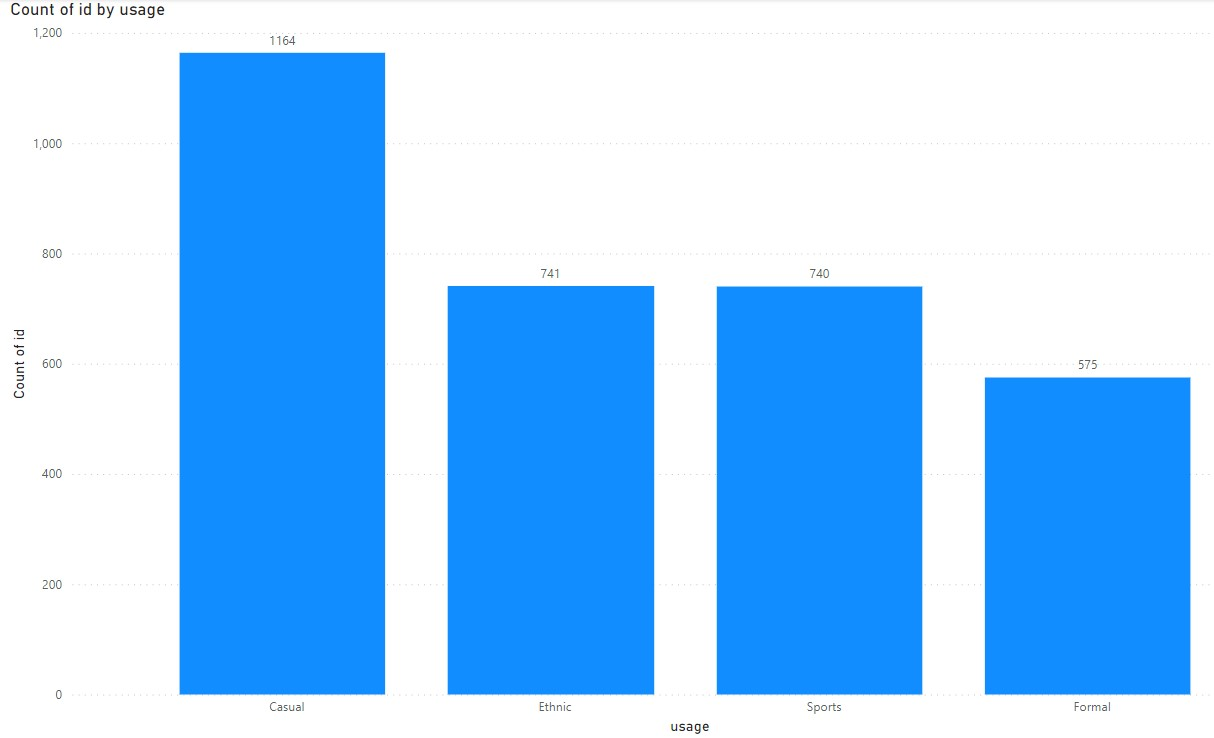\
However, despite our best efforts cleaning and feature engineering (e.g. trying to scrape the web for more images to add to our smaller classes), we were still not able to achieve a high testing accuracy since the model still skews towards casual.\
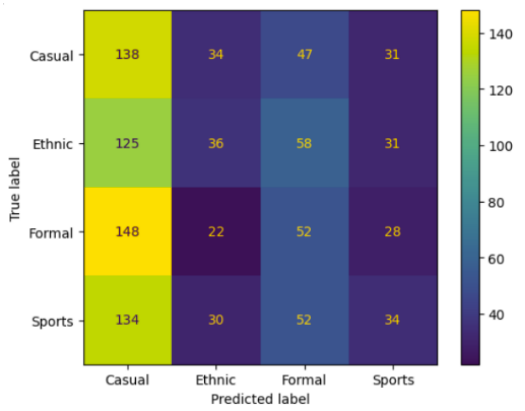\
We believe that this was the case due to there still being inconsistencies in the training data. For example, the dataset contained multiple article types within each style category, such as upperwear, bottomwear, and footwear, which made it a lot harder for the model to recognize style labels. Further exacerbating these challenges was the inconsistency in the images, as some included fashion models wearing the article of clothing while others did not. Lastly, we were faced with hardware constraints combined with using Google Colab which made it infeasible to train our model for extended periods of time.

>### **Data Visualizations**
To overcome these difficulties in accurately predicting style labels, we shifted our approach towards a binary classification problem, with a specific focus on footwear since there was more uniformity amongst images and class labels comparing formal and informal.
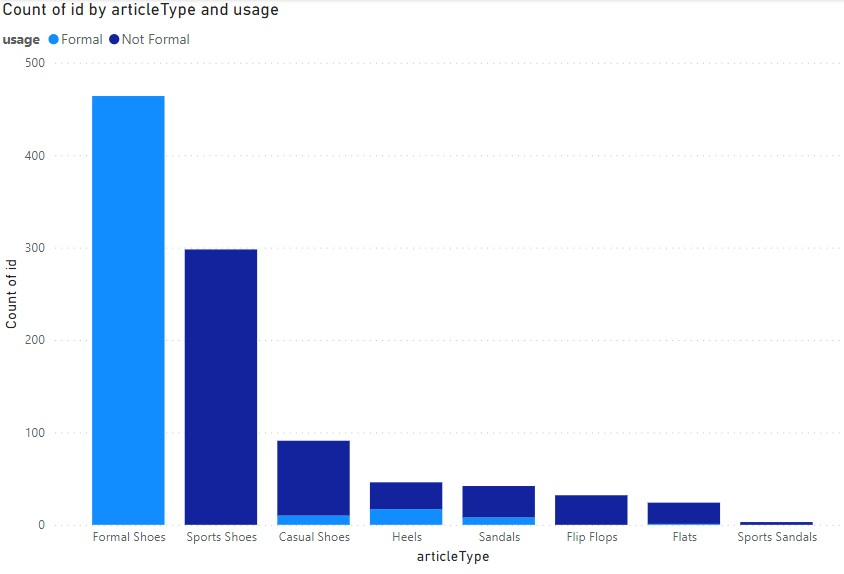
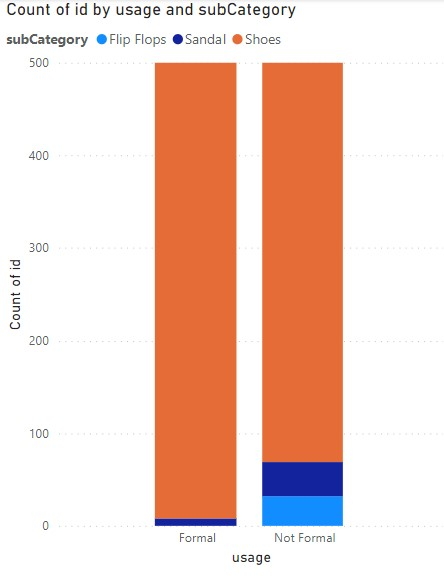\
By adopting this approach, we were able to develop a more effective and accurate model, achieving significant improvements in performance. Our model's ability to distinguish between formal and informal shoes still provides valuable insights for various industries, such as fashion and retail, where this information can be leveraged to inform inventory decisions and consumer preferences.

>## **Machine Learning**
Classifying an article of clothing to a style label can be very complex in nature since there is no easily identifiable linear relationship between an image of clothing and its style. To handle this complexity, our team employed a Convolutional Neural Network (CNN). The CNN architecture incorporates convolutional layers that enables the network to detect intricate patterns in clothing images, such as edges, corners, and textures. These layers work alongside other hidden layers allowing the network to learn and classify shoe styles with enhanced precision and efficiency.\
\
Upon conducting preliminary research on CNNs, our team decided that leveraging a pre-trained model would be advantageous for our shoe style classifier as a way to save time and resources on the development process. The VGG16 CNN model was selected as it had already been trained on a vast dataset of images (ImageNet), which made it an ideal starting point. By utilizing the model's feature extraction capabilities, we were able to avoid the need to train our model from scratch and instead implemented transfer learning techniques. This allowed us to build on the existing model's knowledge and fine-tune it to identify shoe styles using our custom dataset of images.\
\
Model performance was improved upon iteratively by comparing the confusion matrices of different neural networks after parameter tuning. We explored various hyperparameters such as batch size, optimizer learning rate, number of epochs, and activation functions (e.g., relu vs softmax). In addition, we experimented with adding or removing layers from the VGG16 model to enhance its performance on our custom dataset of shoe images. By fine-tuning these parameters, we were able to optimize the model's accuracy and efficiency for shoe style classification. To further evaluate the trained model's performance, we tested it on individual images sourced from the web. The model demonstrated robust performance, accurately classifying shoe styles even after image augmentation. These results suggest that our trained model has learned to recognize the unique features to differentiate between formal and informal shoes.

# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing import image
from keras import layers, Sequential
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from google.colab import drive
from keras.callbacks import ModelCheckpoint
print(tf.__version__)
drive.mount('/content/drive', force_remount=True)

2.12.0
Mounted at /content/drive


# **Read In Data**
**Training dataset containing images:** train_set_shoes_1000\
\
**validation dataset containing images:** val_set_shoes\
\
**Testing dataset containing images:** test_set_shoes

In [ ]:
#displays first 5 rows of training set data.
#NOTE: our model is trained using a folder containing subdirectories for each class. Each subdirectory contains image files forresponding to the class
#this csv is to show you what our intial data looks like before the images were extracted.
styles_df = pd.read_csv('/content/drive/MyDrive/MSCI_446_Project/train_set_shoes.csv')
styles_df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,link
0,9036,Men,Footwear,Shoes,Formal Shoes,Black,Winter,2011,Formal,Buckaroo Men Flores Black Formal Shoes,http://assets.myntassets.com/v1/images/style/p...
1,10268,Men,Footwear,Shoes,Formal Shoes,Black,Fall,2012,Formal,Clarks Men Hang Work Leather Black Formal Shoes,http://assets.myntassets.com/v1/images/style/p...
2,59435,Men,Footwear,Shoes,Formal Shoes,Black,Summer,2012,Formal,Arrow Men Black Formal Shoes,http://assets.myntassets.com/v1/images/style/p...
3,23247,Men,Footwear,Shoes,Formal Shoes,Black,Fall,2011,Formal,Arrow Men Formal Black Shoe,http://assets.myntassets.com/v1/images/style/p...
4,10633,Men,Footwear,Shoes,Formal Shoes,Brown,Fall,2011,Formal,Carlton London Men Formal Brown Formal Shoes,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
#define the file path to the training, validation, and testing sets
train_set_path = '/content/drive/MyDrive/MSCI_446_Project/train_set_shoes_1000'
test_set_path = '/content/drive/MyDrive/MSCI_446_Project/test_set_shoes'
val_set_path = '/content/drive/MyDrive/MSCI_446_Project/val_set_shoes'

# **Data Preprocessing**

In [ ]:
#augmented data generators for training set for better variability in the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#rescaled data generators for validation and testing sets
val_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
#define the training, validation, and testing sets
train_set = train_datagen.flow_from_directory(
    train_set_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_set = val_datagen.flow_from_directory(
    val_set_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_set = test_datagen.flow_from_directory(
    test_set_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 982 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


# **Creating & Fitting The Model**


In [ ]:
#define vGG16 model
vgg16_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

#make VGG16 layers not trainable
for layer in vgg16_model.layers:
  layer.trainable = False

#get the output of the last layer of VGG16
last_layer = vgg16_model.get_layer('block5_pool')
last_output = last_layer.output

#add a GlobalMaxPooling2D to the last layer of VGG16
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)

#add a relu layer with 512 neurons
x = tf.keras.layers.Dense(512, activation='relu')(x)

#add a dropout layer with rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

#add a sigmoid layer with 2 neurons for our binary classification
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

#define our model
model = Model(vgg16_model.input, x)

# Print model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

>To run the model that we trained, load the weights, compile the model, but **do not fit the model**. Skip to model evaluation section

In [ ]:
#loads the weights of our trained model
model.load_weights("/content/drive/MyDrive/MSCI_446_Project/model_shoes2.hdf5")

In [ ]:
#compile the model with tuned learning rate
tunedOptimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=tunedOptimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
#model checkpoints for saving weights (make sure to change checkpoint path)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/MSCI_446_Project/model_shoes_test.hdf5",
                             monitor='loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',
                             save_freq=1)

In [ ]:
# Fit the model with 5 epochs
model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=5,
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[checkpoint],
    verbose = 1,
    shuffle=True
)

Epoch 1/5

Epoch 1: loss improved from inf to 0.73333, saving model to /content/drive/MyDrive/MSCI_446_Project/model_shoes2.hdf5
 1/31 [..............................] - ETA: 12:28 - loss: 0.7333 - acc: 0.4688
Epoch 1: loss did not improve from 0.73333
 2/31 [>.............................] - ETA: 10:24 - loss: 1.0083 - acc: 0.4375
Epoch 1: loss did not improve from 0.73333
 3/31 [=>............................] - ETA: 8:41 - loss: 0.9570 - acc: 0.4651 
Epoch 1: loss did not improve from 0.73333
 4/31 [==>...........................] - ETA: 8:48 - loss: 0.9582 - acc: 0.4746
Epoch 1: loss did not improve from 0.73333
 5/31 [===>..........................] - ETA: 10:10 - loss: 0.9506 - acc: 0.4600
Epoch 1: loss did not improve from 0.73333
 6/31 [====>.........................] - ETA: 10:18 - loss: 0.9690 - acc: 0.4396
Epoch 1: loss did not improve from 0.73333
 7/31 [=====>........................] - ETA: 9:44 - loss: 0.9629 - acc: 0.4346 
Epoch 1: loss did not improve from 0.73333
 8/3

In [ ]:
#saves model
model.save('/content/drive/MyDrive/MSCI_446_Project/model_shoes_test.hdf5')

# **Model Evaluation**

>## **Interpretation & Discussion of Our Results**
To evaluate the accuracy of our model, we used the keras predict function and the scikit-learn confusion matrix to visualize our testing accuracy. Our most successful model had an accuracy of 94.95% on our testing dataset which contains 218 images that are different from the training or validation sets. It correctly classified 129 out of 132 "Formal" shoes and 78 out of 86 "Not Formal" shoes, resulting in an overall accuracy of 207 out of 218 images predicted correctly. It was unsurprising to observe that the model excelled in distinguishing formal and informal shoes as they have distinguishable characteristics. As such, the CNN was easily able to recognize similarities in each class to predict each category accurately, especially compared to our initial approach with each class containing topwear, bottomwear, and shoes. It performed slightly worse for informal shoes likely because that class contains shoes from multiple different styles so it is a bit more challenging to find similarities between them.\
\
After researching and discussing with course TAs, it was decided that cross validation was not necessary for our model. According to a Stack Exchange post linked below, CNNs such as VGGNet tend to overfit rather than underfit, and averaging multiple models is more useful than selecting the best one. This is because CNNs have a tendency to have variance errors rather than biased errors. Additionally, the number of hyperparameters for CNNs is almost infinite, making it difficult to apply cross validation effectively (HunarHunar, 2019).\
\
The code we used to evaluate our model is shown below:


In [ ]:
#predict model using test set
y_true = test_set.classes
y_pred = model.predict(test_set).argmax(axis=-1)

7/7 [==============================] - 116s 16s/step


In [ ]:
#display accuracy score
score = accuracy_score(y_true,y_pred)
print("Accuracy Score: " + str(score*100) + "%")

Accuracy Score: 94.95412844036697%


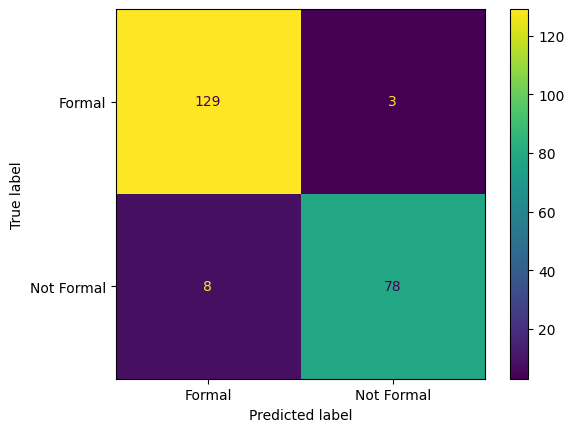

In [ ]:
#displays confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Formal', 'Not Formal'])
cm_display.plot()
plt.show()

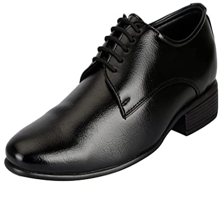

1/1 [==============================] - 1s 563ms/step
This image belongs to the class: Formal


In [ ]:
#Test model prediction with a formal shoe
img = Image.open('/content/drive/MyDrive/MSCI_446_Project/formalshoe.jpg')
img = img.resize((224, 224))
display(img)
img = tf.keras.utils.array_to_img(img)
img = np.expand_dims(img, axis=0)
img = img/255.0
pred = model.predict(img)
class_names = ['Formal', 'Not Formal']
class_idx = np.argmax(pred)
class_name = class_names[class_idx]
print('This image belongs to the class:', class_name)

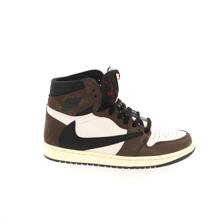

1/1 [==============================] - 0s 433ms/step
This image belongs to the class: Not Formal


In [ ]:
#Test model prediction with a not formal shoe
img = Image.open('/content/drive/MyDrive/MSCI_446_Project/shoes_test.jpg')
img = img.resize((224, 224))
display(img)
img = tf.keras.utils.array_to_img(img)
img = np.expand_dims(img, axis=0)
img = img/255.0
pred = model.predict(img)
class_names = ['Formal', 'Not Formal']
class_idx = np.argmax(pred)
class_name = class_names[class_idx]
print('This image belongs to the class:', class_name)

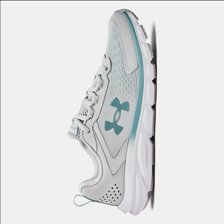

1/1 [==============================] - 0s 457ms/step
This image belongs to the class: Not Formal


In [ ]:
#Test model prediction with a rotated not formal shoe
img = Image.open('/content/drive/MyDrive/MSCI_446_Project/rotate.jpg')
img = img.resize((224, 224))
display(img)
img = tf.keras.utils.array_to_img(img)
img = np.expand_dims(img, axis=0)
img = img/255.0
pred = model.predict(img)
class_names = ['Formal', 'Not Formal']
class_idx = np.argmax(pred)
class_name = class_names[class_idx]
print('This image belongs to the class:', class_name)

>## **Surprising & Unexpected Results**
During our project, we were surprised by the amount of time we dedicated to data collection, cleaning, and preparation, which amounted to approximately 75% of our total project time. The Kaggle data we used had poor quality, requiring us to manually review individual records and eliminate those that did not fit the intended class. We discovered that data cleaning had the most significant impact on the accuracy of our model. Once we refined the dataset to only include formal and non-formal footwear and removed any mislabeled images, our model's accuracy skyrocketed from being barely better than a random probability to over 90%. We also observed that our CNN struggled to find similarities between different article types within each class, such as shoes and shirts under the "Formal" class. However, reducing the dataset to solely shoes allowed the model to perform significantly better.\
\
Another surprising finding was the considerable impact of data preprocessing on the model's performance. We learned that data augmentation is typically implemented on the training set to help small models become more generalized and robust (Rodrigo-Silveira, 2017). Augmenting our training set helped prevent overfitting and improved our test accuracy considerably (Awan, 2022).\
\
Lastly, we were surprised by how slight changes to the model's parameters, such as the learning rate, batch size, or number of epochs, could have such a significant impact on its performance. These changes altered the training time and accuracy of the model with minimal effort.



# **Conclusion**

>## **Summary**
In this project, we aimed to classify an article of clothing to a style label using machine learning. We developed a binary classification model to identify formal and informal shoes. We also improved its performance by doing parameter tuning and evaluating on several datasets. We used a CNN and implemented transfer learning techniques to build on an existing pretrained VGG16 model's knowledge and fine-tuned it to identify formal and informal shoes using a custom dataset of images. The model's performance was iteratively improved upon by comparing the confusion matrices of different neural networks after parameter tuning. We explored various hyperparameters such as batch size, optimizer learning rate, number of epochs, and activation functions to optimize the model's accuracy and efficiency for clothing style classification. Ultimately, we achieved an accuracy of 94.41%.\
\
We found that data cleaning and preparation had the most significant impact on the accuracy of the model, and data preprocessing, such as data augmentation, helped prevent overfitting and improved the test accuracy considerably. We also discovered that slight changes to the model's parameters, such as the learning rate, batch size, or number of epochs, could have a significant impact on its performance.

>## **Real World Implications**
In the real world, this translates to students being able to identify their shoe styles and use this knowledge to curate outfits that complement their personal fashion sense. By leveraging this information, students can make more informed decisions when it comes to their shoe selection, whether that means maximizing their existing wardrobe or identifying missing pieces to complete outfits. This empowers them to make more sustainable and conscious shopping choices.

>## **Most Important/Surprising Things Learned**
During this project, we discovered several valuable and unexpected insights into machine learning. We learned how important data quality is in the performance of machine learning models. We found that high-quality, well-labeled images resulted in significantly better performance. While this may seem intuitive, it was still surprising to see the extent to which data quality can impact model accuracy. This project emphasized the importance of carefully curating and preprocessing data to ensure optimal results in any machine learning project.\
\
Also, we were surprised by the impact of the number of trainable layers had on the training time of our models, and the limitations that hardware constraints imposed on the training process by Google Colab. Early in the project, we attempted to train our model with millions of trainable parameters using VGG16 for classifying 3000 images into 4 classes. However, this required a significant amount of time and resulted in overfitting. Each epoch took approximately 40-50 minutes to complete, which led to considerable waiting time before any additional parameter changes could be made. Consequently, when we modified the scope of our project to focus solely on binary classification, we reduced the number of trainable parameters which allowed us to effectively train our model within a more reasonable time frame.\
\
Lastly, we learned that parameter tuning is a critical aspect of achieving high accuracy in machine learning models. During our experimentation with various hyperparameters, including learning rate, dropout rate, and number of filters, we discovered that adjusting these parameters can significantly improve model performance. Fine-tuning hyperparameters was a bit of a tedious process, but it was essential to finding an optimal combination that yielded 90%+ accuracy. This project emphasized the importance of selecting and optimizing hyperparameters in any machine learning project to maximize performance.


>## **Next Steps**
The following steps for those interested in advancing the project involve acquiring and training on additional data that accurately represent how the clothing appears in real-life scenarios. As the current model is mainly composed of well-lit images with a white background, it may not be indicative of real-world conditions where images could be dimly lit, poorly framed, or contain background elements that can affect the outcomes. Additionally, the model currently covers only Formal and Non Formal Shoes, but there are numerous other styles, such as streetwear, high-fashion, and semi-formal that need to be included in the model. Instead of grouping all clothing types into one style for example a dataset of casual clothing containing topwear, bottomwear, and shoes, each type and style should be a unique class. Resulting in a class for casual topwear, casual bottomwear, and causal shoes, this way the model doesn't have to cluster the correlations of each type with each style, lowering the overall complexity. Finally, further testing would also be necessary to ensure that the model can detect the subtle characteristics that come with each new style addition.


# **Bibliography**

>Aggarwal, Param. “Fashion Product Images Dataset.” Kaggle, 14 Mar. 2019, https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset.

>The AI University. “How to Utilize Pre-Trained Models for Building Deep Learning Models: VGG16 Resnet Object Detection.” YouTube, 3 July 2020, https://youtu.be/_PXXkTudkf8.

>Awan, Abid Ali. “A Complete Guide to Data Augmentation.” DataCamp, DataCamp, 23 Nov. 2022, https://www.datacamp.com/tutorial/complete-guide-data-augmentation.

>HunarHunar, et al. “Using Cross Validation Technique for a CNN Model.” Data Science Stack Exchange, 22 Mar. 2019, https://datascience.stackexchange.com/questions/47797/using-cross-validation-technique-for-a-cnn-model#:~:text=Any%20time%20you%20have%20models,tendency%20toward%20overfitting%20not%20underfitting.

>José, Italo. “Saving Your Weights for Each Epoch - Keras Callbacks.” Medium, Medium, 22 Aug. 2019, https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202.

>Kandel, Ibrahem, and Mauro Castelli. “The Effect of Batch Size on the Generalizability of the Convolutional Neural Networks on a Histopathology Dataset.” ICT Express, Elsevier, 5 May 2020, https://www.sciencedirect.com/science/article/pii/S2405959519303455#:~:text=In%20practical%20terms%2C%20to%20determine,advantage%20of%20the%20GPUs%20processing.

>LuciferLucifer 4722 silver badges88 bronze badges, et al. “How to Remove the Last Layer from a Pre-Trained Model. I Have Tried Model.layers.pop() but It Is Not Working.” Stack Overflow, 1 Jan. 1966, https://stackoverflow.com/questions/55335228/how-to-remove-the-last-layer-from-a-pre-trained-model-i-have-tried-model-layers.

>“Machine Learning - Confusion Matrix.” Python Machine Learning - Confusion Matrix, w3schools, https://www.w3schools.com/python/python_ml_confusion_matrix.asp.

>Munawar, Muhammad Rizwan. “Image Classification Using Transfer Learning (VGG-16).” Medium, Nerd For Tech, 26 May 2022, https://medium.com/nerd-for-tech/image-classification-using-transfer-learning-vgg-16-2dc2221be34c.

>Petro, Greg. “Sustainable Retail: How Gen Z Is Leading the Pack.” Forbes, Forbes Magazine, 12 Oct. 2022, https://www.forbes.com/sites/gregpetro/2020/01/31/sustainable-retail-how-gen-z-is-leading-the-pack/?sh=2b6004a82ca3.

>Pramoditha, Rukshan. “How to Choose the Optimal Learning Rate for Neural Networks.” Medium, Towards Data Science, 6 Oct. 2022, https://towardsdatascience.com/how-to-choose-the-optimal-learning-rate-for-neural-networks-362111c5c783.

>Rodrigo-Silveira, et al. “Data Augmentation in Test/Validation Set?” Stack Overflow, 29 Dec. 2017, https://stackoverflow.com/questions/48029542/data-augmentation-in-test-validation-set.

>“Sklearn.metrics.confusion_matrix.” Scikit, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html.

>welfredwelfred 1133 bronze badges, et al. “Caffe: Variable Input-Image Size for Vgg Network.” Stack Overflow, 1 Sept. 1963, https://stackoverflow.com/questions/40530162/caffe-variable-input-image-size-for-vgg-network.



